In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A

from datasets.lungdatasets import SchenzenMontgomeryLungSegmentationDataset
from datasets.lungdatasets import CheXpertLungSegmentationDataset
from models.unet import ResNetUNet
from utils.utils import bce_dice_loss, dice_metric
import numpy as np
from tqdm import tqdm
import glob
import cv2

CHEXPERT_TRAIN = '../CheXpert-v1.0-small/train.csv'
BASE_MASKS = './intermediate/out_lung_mask3/'
BASE_IMG = './data/chexpert-cardio-nofinding/'
BASE_EXTRA = 'CheXpert-v1.0-small/train/'

def get_transforms(size, test = True):
    #TODO: Do test-time augmentation?
    if test:
        return A.Compose([
        A.Resize(height=size, width=size, p=1.0)
        ])
    return A.Compose([
        A.Resize(height=size, width=size, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=45, p=0.3),
    ])

#Find Min skipping 0
def find_min(arr):
    min_val = 1000
    for idx, value in enumerate(arr):
        if value < min_val and value != 0:
            min_val = value
    return min_val

def find_chest_width_image(img,post_process=True):
    if post_process:
        img = post_process_image(img)
    start = np.argmax(img[:,:,1],axis=1)
    end = np.argmax(img[:,::-1,1],axis=1)
    h,w,c = img.shape
    return find_min(start), w - find_min(end), w

def find_chest_width(path,post_process=True):
    img = cv2.imread(path)
    if post_process:
        img = post_process_image(img)
    start = np.argmax(img[:,:,1],axis=1)
    end = np.argmax(img[:,::-1,1],axis=1)
    h,w,c = img.shape
    return find_min(start), w - find_min(end), w

def post_process_image(img,hull = True):
    
    dst = img[:,:,0]
    
    #kernel = np.ones((3, 3), np.uint8)
    #dst = cv2.erode(dst, kernel,iterations= 3) 

    contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #create an empty image for contours
    img_contours = np.zeros(img.shape)
    # draw the contours on the empty image
    cs = [(c,cv2.contourArea(c)) for c in contours]
    cs.sort(key=lambda x:x[1])
    if hull:
        hulls = [cv2.convexHull(p[0]) for p in cs[-2:]]
        cv2.drawContours(img_contours, hulls, -1, (0,255,0), -1)
    else:
        contours2 = [p[0] for p in cs[-2:]]
        cv2.drawContours(img_contours, contours2, -1, (0,255,0), -1)
    return img_contours

def find_img(path):
    img = cv2.imread(path)
    return img.shape

import numpy as np
import cv2
from matplotlib.pyplot import imshow

ds_train_no_finding = CheXpertLungSegmentationDataset("./data/hand-label/nofinding.json", '../CheXpert-v1.0-small/train/'
                                                      , aug_transform=get_transforms(320)
                                                     , test = True)
ds_train_cardiomegaly = CheXpertLungSegmentationDataset("./data/hand-label/cardiomegaly-certain.json", '../CheXpert-v1.0-small/train/'
                                                        , aug_transform=get_transforms(320)
                                                       , test = True)

full_ds_chexpert1 = torch.utils.data.ConcatDataset([ds_train_no_finding, ds_train_cardiomegaly])
train_ds_chexpert1,val_ds_chexpert1 = torch.utils.data.random_split(full_ds_chexpert1, [len(full_ds_chexpert1) - 100, 100], generator=torch.Generator().manual_seed(42))
sample = np.uint8(full_ds_chexpert1[0][1].cpu().numpy() * 255)

./data/hand-label/nofinding.json
./data/hand-label/cardiomegaly-certain.json


In [2]:
ignore = [x[2] for x in val_ds_chexpert1]

In [3]:
#Find Min skipping 0
def find_min(arr):
    min_val = 1000
    for idx, value in enumerate(arr):
        if value < min_val and value != 0:
            min_val = value
    return min_val

def find_chest_width(path,post_process=True):
    img = cv2.imread(path)
    if post_process:
        img = post_process_image(img)
    start = np.argmax(img[:,:,1],axis=1)
    end = np.argmax(img[:,::-1,1],axis=1)
    h,w,c = img.shape
    return find_min(start), w - find_min(end), w

def post_process_image(img,hull = True):
    
    dst = img[:,:,0]
    
    #kernel = np.ones((3, 3), np.uint8)
    #dst = cv2.erode(dst, kernel,iterations= 3) 

    contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #create an empty image for contours
    img_contours = np.zeros(img.shape)
    # draw the contours on the empty image
    cs = [(c,cv2.contourArea(c)) for c in contours]
    cs.sort(key=lambda x:x[1])
    if hull:
        hulls = [cv2.convexHull(p[0]) for p in cs[-2:]]
        cv2.drawContours(img_contours, hulls, -1, (0,255,0), -1)
    else:
        contours2 = [p[0] for p in cs[-2:]]
        cv2.drawContours(img_contours, contours2, -1, (0,255,0), -1)
    return img_contours

def find_img(path):
    img = cv2.imread(path)
    return img.shape

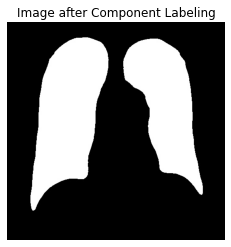

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


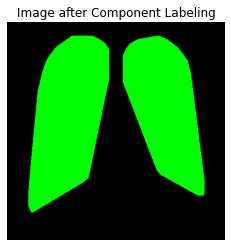

In [4]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = cv2.imread(BASE_MASKS + 'patient00005_study1_view1_frontal.jpg')

plt.imshow(cv2.cvtColor(img[:,:,0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image after Component Labeling")
plt.show()

plt.imshow(post_process_image(img))
plt.axis('off')
plt.title("Image after Component Labeling")
plt.show()

In [5]:
find_chest_width(BASE_MASKS + 'patient00005_study1_view1_frontal.jpg',post_process=True)

(50, 464, 512)

In [6]:
find_chest_width(BASE_MASKS + 'patient00005_study1_view1_frontal.jpg',post_process=False)

(55, 460, 512)

In [7]:
(img[:,:,0] > 0)[100]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [8]:
import pandas as pd

df = pd.read_csv(CHEXPERT_TRAIN)
df = df.fillna(0)
df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
import pickle
import cv2


with open('./intermediate/out_heartmodel2AFTERPRETRAINING4.pickle', 'rb') as handle:
     out_heart = pickle.load(handle)
        
with open('./intermediate/out_pathsmodel2AFTERPRETRAINING4.pickle', 'rb') as handle:
     out_paths = pickle.load(handle)

In [10]:
import numpy as np
from tqdm import tqdm

def calculate_ctr(top_k=5):
    ctr_count_no = 0
    ctr_amount_no = 0

    ctr_count_un = 0
    ctr_amount_un = 0

    ctr_count = 0
    ctr_amount = 0

    ctr_healthy = []
    ctr_uncertain = []
    ctr_cardiomegaly = []
    
    processed = []

    for path, heart in tqdm(list(zip(out_paths,out_heart))):
        #if path in ignore:
        #    continue
        boxes = heart[1]['boxes']
        #print(path)
        boxes_to_consider = boxes[0:top_k]
       
        widths_in_pixels = (boxes_to_consider[:,2] - boxes_to_consider[:,0]).cpu().numpy() 
        min_val,max_val,width = find_chest_width(BASE_MASKS + path)

        h,w,c = find_img(BASE_IMG + path)
        heart = widths_in_pixels.sum()/(top_k*w)
        chest = (max_val-min_val)/width

        row = df[df.Path.eq(BASE_EXTRA + path.replace('_','/',2))]
        #print('-------------------')
        #print(abs(row[row.columns[5:]].sum()).sum())
        #print(row['Sex'].values[0])
        #print(row['Support Devices'].values[0])
        #print(row['Cardiomegaly'])
        #print(row['No Finding'].values)
        clazz = -1
        uncertain = False
        if row['No Finding'].values[0] == 1:
            ctr_count_no += 1
            ctr_amount_no += heart/chest
            ctr_healthy.append(heart/chest)
            clazz = 0
        elif row['Cardiomegaly'].values[0] == 1:
            ctr_count += 1
            ctr_amount += heart/chest
            ctr_cardiomegaly.append(heart/chest)
            clazz = 1
        else:
            ctr_count_un += 1
            ctr_amount_un += heart/chest
            ctr_uncertain.append(heart/chest)
            uncertain = True
            clazz = 1
            
        ctr =  heart/chest
        processed.append(
            (path,ctr,clazz,heart,chest,boxes_to_consider,uncertain,
             row['Sex'].values[0],row['Support Devices'].values[0],abs(row[row.columns[5:]].sum()).sum())
        )
    return processed,ctr_amount_no,ctr_count_no,ctr_amount_un,ctr_count_un,ctr_amount,ctr_count,ctr_healthy,ctr_cardiomegaly,ctr_uncertain
    

In [11]:
p, ctr_amount_no,ctr_count_no,ctr_amount_un,ctr_count_un,ctr_amount,ctr_count,ctr_healthy,ctr_cardiomegaly,ctr_uncertain = calculate_ctr(top_k=1)

100%|██████████████████████████████████████████████████████████████████████████████| 9547/9547 [04:05<00:00, 38.86it/s]


In [26]:
optimal_threshold = 0
optimal_accuracy = 0

for i in range(100):
    threshold = i/100
    c = 0
    for example in p:
        prediction = -1
        #if example[2] == -1:
        #    continue
        if example[1] >= threshold:
            prediction = 1
        else:
            prediction = 0
        correct = prediction == example[2]
        if correct:
            c += 1

    if c/(len(p)) > optimal_accuracy:
        optimal_accuracy = c/(len(p))
        optimal_threshold = threshold
        
print(optimal_threshold, optimal_accuracy)

0.49 0.8466533989734996


In [13]:
ctr_amount_no/ctr_count_no,ctr_amount_un/ctr_count_un,ctr_amount/ctr_count

(0.42331256302297415, 0.5300672856718884, 0.5670692324419939)

In [14]:
print(len(ctr_uncertain))
print(len([x for x in ctr_uncertain if x<.55 and x > .45]))
print(len([x for x in ctr_cardiomegaly if x<.55 and x > .45]))
print(len([x for x in ctr_healthy if x<.55 and x > .45]))

1139
612
962
1438


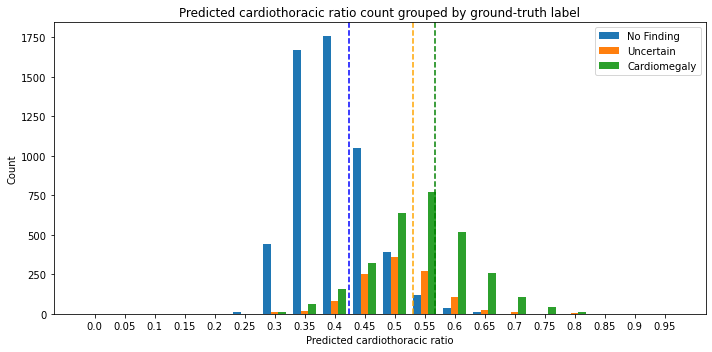

In [15]:
import matplotlib.pyplot as plt
import numpy as np

distributionA = np.random.normal(0.3, 0.1, 1000)
distributionB = np.random.normal(0.5, 0.1, 1000)
distributionC = np.random.normal(0.7, 0.1, 1000)

labels = np.array(range(20))/20
no_finding = np.histogram(ctr_healthy,bins=np.arange(21)/20)
uncertain = np.histogram(ctr_uncertain,bins=np.arange(21)/20)
cardiomegaly = np.histogram(ctr_cardiomegaly,bins=np.arange(21)/20)

x = np.arange(len(labels)) *2 # the label locations
width = 0.5# the width of the bars



fig, ax = plt.subplots(figsize=(10,5))

plt.axvline(x=np.average(ctr_healthy)*40, color='blue', linestyle='--')
plt.axvline(x=np.average(ctr_uncertain)*40, color='orange', linestyle='--')
plt.axvline(x=np.average(ctr_cardiomegaly)*40, color='green', linestyle='--')

rects1 = ax.bar(x - width, no_finding[0], width, label='No Finding')
rects2 = ax.bar(x, uncertain[0], width, label='Uncertain')
rects3 = ax.bar(x + width, cardiomegaly[0] , width, label='Cardiomegaly')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Predicted cardiothoracic ratio')
ax.set_title('Predicted cardiothoracic ratio count grouped by ground-truth label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()


In [16]:
p[0]

('patient00004_study1_view1_frontal.jpg',
 0.4123040490408327,
 0,
 0.3027857860143615,
 0.734375,
 tensor([[161.1936, 175.3953, 273.5271, 243.1840]], device='cuda:0'),
 False,
 'Female',
 0.0,
 1.0)

In [17]:
ctr_count_no,ctr_count_un,ctr_count

(5499, 1139, 2909)

In [18]:
wrong_uncertain = [x for x in p if x[1] < 0.50  and x[2] == 1 and x[6] is True]
wrong_certain = [x for x in p if x[1] < 0.50  and x[2] == 1 and x[6] is False]
len(wrong_certain), len(wrong_uncertain)
wrong = [x for x in p if x[1] > 0.55  and x[2] == 0]

(554, 366)

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

img = cv2.imread(BASE_MASKS + wrong[idx][0])
path = '../CheXpert-v1.0-small/train/' + wrong[idx][0].replace('_','/',2)
img2 = cv2.imread(path)

h,w,c = find_img(BASE_IMG + wrong[idx][0])
print(wrong[idx])
x0,y0,x1,y1 = wrong[idx][5].cpu().numpy()[0]
#x0,y0,x1,y1
print('Box ', x0,y0,x1,y1)
img3 = cv2.rectangle(img2, (x0,y0), (x1,y1), (0, 0, 255), 2)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img[:,:,0])
axarr[1].imshow(post_process_image(img,hull=False))
axarr[2].imshow(img3)

print(df[df.Path == 'CheXpert-v1.0-small/train/' + wrong[idx][0].replace('_','/',2)])
print(idx)
idx +=1


In [71]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.pyplot import figure

def show_image(image_path,bounding_box):
    plt.rcParams["figure.figsize"] = (20,10)

    img = cv2.imread(BASE_MASKS + image_path)
    path = '../CheXpert-v1.0-small/train/' + image_path.replace('_','/',2)
    img2 = cv2.imread(path)

    h,w,c = find_img(BASE_IMG + image_path)
    x0,y0,x1,y1 = bounding_box
    print('Box ', x0,y0,x1,y1)
    img3 = cv2.rectangle(img2, (x0,y0), (x1,y1), (0, 0, 255), 2)

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(img[:,:,0])
    axarr[1].imshow(post_process_image(img,hull=False))
    axarr[2].imshow(img3)

    print(df[df.Path == 'CheXpert-v1.0-small/train/' + image_path.replace('_','/',2)])



In [64]:
p[0]

('patient00004_study1_view1_frontal.jpg',
 0.4123040490408327,
 0,
 0.3027857860143615,
 0.734375,
 tensor([[161.1936, 175.3953, 273.5271, 243.1840]], device='cuda:0'),
 False,
 'Female',
 0.0,
 1.0)

In [65]:
[x for x in p if x[8] != 1 and x[8] != 0]

[('patient00528_study3_view1_frontal.jpg',
  0.6194944220074152,
  1,
  0.5710964202880859,
  0.921875,
  tensor([[ 91.4312, 183.0163, 274.1821, 280.8293]], device='cuda:0'),
  False,
  'Male',
  -1.0,
  2.0),
 ('patient01167_study48_view1_frontal.jpg',
  0.5299665646853147,
  1,
  0.4554400165264423,
  0.859375,
  tensor([[111.0436, 176.6709, 259.0616, 261.5815]], device='cuda:0'),
  False,
  'Male',
  -1.0,
  2.0),
 ('patient01467_study2_view1_frontal.jpg',
  0.5464127280680665,
  1,
  0.43542264267924047,
  0.796875,
  tensor([[130.4996, 150.1302, 290.2997, 242.3418]], device='cuda:0'),
  True,
  'Male',
  -1.0,
  2.0),
 ('patient01595_study25_view1_frontal.jpg',
  0.4880286907327586,
  1,
  0.4422760009765625,
  0.90625,
  tensor([[102.5537, 204.4142, 244.0820, 268.1316]], device='cuda:0'),
  False,
  'Male',
  -1.0,
  2.0),
 ('patient01798_study3_view1_frontal.jpg',
  0.5666956974909856,
  0,
  0.46044025421142576,
  0.8125,
  tensor([[115.7035, 148.5917, 263.0444, 223.1403]], dev

In [98]:
np.unique(np.array([x[9] for x in p]))

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [150]:
correct =  np.array([x[2] for x in p if x[9] == 1])
predicted =  np.array([x[1] for x in p  if x[9] == 1]

In [136]:
correct2 =  np.array([x[2] for x in p if x[9] == 2])
predicted2 =  np.array([x[1] for x in p  if x[9] == 2])

In [137]:
correct3 = np.array([x[2] for x in p if x[9] == 3])
predicted3 = np.array([x[1] for x in p  if x[9] == 3])

In [138]:
correct4 = np.array([x[2] for x in p if x[9] == 4])
predicted4 = np.array([x[1] for x in p  if x[9] == 4])

In [139]:
correct5 = np.array([x[2] for x in p if x[9] > 5])
predicted5 = np.array([x[1] for x in p  if x[9] > 5])

In [141]:
(correct == (predicted > 0.5)).mean()

0.8796154686475858

In [142]:
(correct2 == (predicted2 > 0.5)).mean()

0.8163948138854036

In [143]:
(correct3 == (predicted3 > 0.5)).mean()

0.7620578778135049

In [144]:
(correct4 == (predicted4 > 0.5)).mean()

0.8179551122194514

In [145]:
(correct5 == (predicted5 > 0.5)).mean()

0.8613861386138614

In [174]:
len(correct5)

303

In [111]:
len(correct), len(correct2), len(correct3), len(correct4), len(correct5)

(4577, 2391, 933, 802, 303)

In [ ]:
sample = [x for x in p if x[0] == 'patient14064_study1_view1_frontal.jpg'][0]
show_image(sample[0],sample[5].cpu().numpy()[0])

wrong_uncertain = [x for x in p if x[1] < 0.50  and x[2] == 1 and x[6] is True]
wrong_certain = [x for x in p if x[1] < 0.50  and x[2] == 1 and x[6] is False]
len(wrong_certain), len(wrong_uncertain)
wrong = [x for x in p if x[1] > 0.55  and x[2] == 0]

In [216]:
study = [x for x in p if x[1] <0.45 and x[2] == 1]
idx = 0
len(study)

346

In [217]:
np.array([x[1] for x in study]).mean()

0.4068295942161499

<ipython-input-71-c713109a7fde>:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img3 = cv2.rectangle(img2, (x0,y0), (x1,y1), (0, 0, 255), 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Box  141.92598 199.96716 246.70085 253.20174
                                                    Path     Sex  Age  \
10200  CheXpert-v1.0-small/train/patient02526/study1/...  Female   68   

      Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
10200         Frontal    PA         0.0                         1.0   

       Cardiomegaly  Lung Opacity  Lung Lesion  Edema  Consolidation  \
10200           1.0           1.0          0.0    0.0            0.0   

       Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
10200        0.0          0.0           0.0               0.0            0.0   

       Fracture  Support Devices  
10200       0.0              0.0  
0.4049270408740942
20


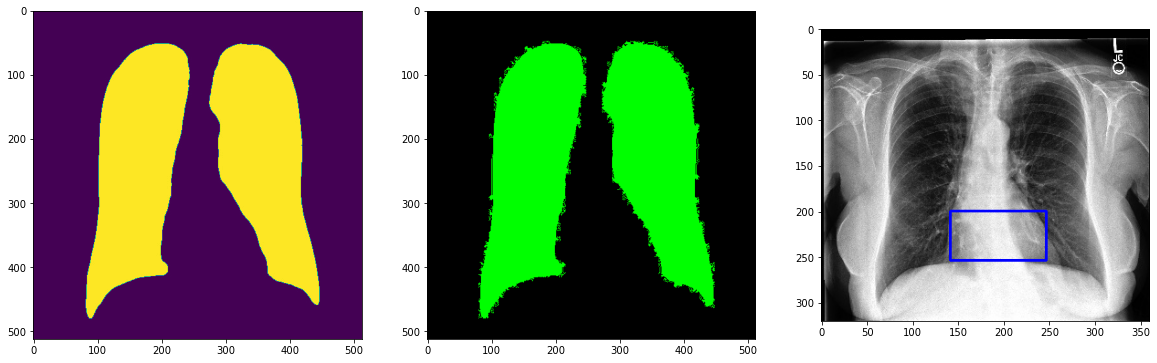

In [238]:
show_image(study[idx][0],study[idx][5].cpu().numpy()[0])
print(study[idx][1])
print(idx)
idx+=1

No Skill: ROC AUC=0.5000000
Logistic: ROC AUC=0.9109574
Logistic: ROC AUC=0.8726050


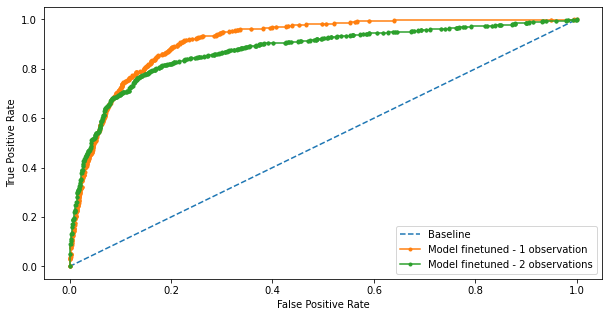

(0.7248585600248004, 0.8085871711515074, 0.7556586947281694, None)

In [149]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(correct))]
ns_auc = roc_auc_score(correct, ns_probs)
lr_auc = roc_auc_score(correct, predicted)
lr_auc2 = roc_auc_score(correct2, predicted2)
#lr_auc3 = roc_auc_score(correct3, predicted3)
#lr_auc4 = roc_auc_score(correct4, predicted4)
#lr_auc5 = roc_auc_score(correct5, predicted5)
print('No Skill: ROC AUC=%.7f' % (ns_auc))
print('Logistic: ROC AUC=%.7f' % (lr_auc))
print('Logistic: ROC AUC=%.7f' % (lr_auc2))
#print('Logistic: ROC AUC=%.7f' % (lr_auc3))
#print('Logistic: ROC AUC=%.7f' % (lr_auc4))
#print('Logistic: ROC AUC=%.7f' % (lr_auc5))

ns_fpr, ns_tpr, _ = roc_curve(correct, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(correct,  predicted)
lr_fpr2, lr_tpr2, _ = roc_curve(correct2,  predicted2)
#lr_fpr3, lr_tpr3, _ = roc_curve(correct3,  predicted3)
#lr_fpr4, lr_tpr4, _ = roc_curve(correct4,  predicted4)
#lr_fpr5, lr_tpr5, _ = roc_curve(correct5,  predicted5)
plt.rcParams["figure.figsize"] = (10,5)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model finetuned - 1 observation')
pyplot.plot(lr_fpr2, lr_tpr2, marker='.', label='Model finetuned - 2 observations')
#pyplot.plot(lr_fpr3, lr_tpr3, marker='.', label='Model finetuned - Uncertain about support devices')
#pyplot.plot(lr_fpr4, lr_tpr4, marker='.', label='Model finetuned - No Support devices')
#pyplot.plot(lr_fpr5, lr_tpr5, marker='.', label='Model finetuned - Uncertain about support devices')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(correct, (np.array(predicted) > 0.50)*1, average='macro')